# 2.1 Library Setup & Data Loading

In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Libraries for Automated Scan
import sweetviz as sv
from ydata_profiling import ProfileReport

e:\Data_Science\envs\telco-churn\lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [ ]:
# Libraries for Redundancy Analysis
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

In [23]:
# Libraries for Feature Selection
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Libraries for Segmentation via UMAP
import umap
from sklearn.preprocessing import StandardScaler

In [6]:
# Import KMeans for Clustering
from sklearn.cluster import KMeans

In [34]:
# Libraries for Statistical Analysis
from scipy.stats import normaltest, skew, kurtosis

In [3]:
# Load The Training Dataset
train_df = pd.read_parquet('../data/processed/train_df.parquet', engine='fastparquet')
print(f"Training DataFrame Shape: {train_df.shape}")
train_df.drop(columns=['customer_id'], inplace=True)

Training DataFrame Shape: (52004, 41)


# 2.2 Automated "First Pass" Scan

This paper discusses the necessity of automated tools to handle the "scale and complexity of modern data," which traditional manual EDA cannot.
* Gaikwad, J., et al. (2024). AI-based exploratory data analysis. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 11(2), 3876–3884. https://doi.org/10.32628/CSEIT25112860

In [5]:
# 'VisibleDeprecationWarning' was removed in NumPy 2.0. 
# We manually map it to UserWarning so Sweetviz finds what it's looking for.
np.VisibleDeprecationWarning = UserWarning

In [ ]:
# Generate a sweetviz report
report = sv.analyze(train_df, target_feat='churn')

# Save the report to a specific file
report.show_html(filepath='../reports/dataset_sweetviz_report.html', 
                 open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/dataset_sweetviz_report.html was generated.


In [8]:
# Automated Profiling Report
profile = ProfileReport(train_df, title="Telco Churn Dataset Report", explorative=True)
profile.to_file('../reports/dataset_profiling_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:06<00:00,  6.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Check for Zero Variance
zero_var_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]

if len(zero_var_cols) == 0:
    print("Confirmed: No columns with zero variance. Every feature has data.")
else:
    print(f"Found {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")

Confirmed: No columns with zero variance. Every feature has data.


### Automated Report Summary
**Objective:** assessed data quality, sparsity, and distribution properties.

**Key Findings:**
* **Data Integrity:** The dataset contains no missing values and no zero-variance columns.
* **Cardinality:** Several continuous features (e.g., `trend_data_w2_vs_w1`) exhibit 100% cardinality (unique values per user), which is expected for high-precision calculated metrics.
* **Correlations:** Several features show high correlations ($|\rho| > 0.7$), which means they are closely associated in their fluctuations. Linear models will suffer if they are kept together.
* **Target Variable:** The churn rate is **23.1%**, requiring recall or f1-score-oriented evaluation metrics or threshold-independent metrics (AUC-ROC) rather than accuracy.
* **Sparsity:**  23% features have high sparsity (1% to 17%), between 83% and 99% of its values are zeros, representing infrequent but potentially significant occurrences like zero data usage.
* **Distribution:** Significant skewness was observed in 4 features (e.g., `trend_spend_w4_vs_w3` with $\gamma_1 \approx 221$), indicating a highly concentrated user behavior pattern.

**Action Taken:**
* A manual Spearman correlation analysis will be performed, confirming strong monotonic relationships anc considering to to drop them after evaluating its IV scores.
* SMOTE will be performed to handle the imbalance or the `class_weight` parameter will be set to `'balanced'` if using LogisticRegression.
* Handling the features with high sparsity by using models naturally robust to sparsity such as ensembe methods, or by grouping related sparse features.
* Data transformation (using StandardScaler) or binning will be performed specifically to handle highly skewed features.

# 2.3 Informatian Value (IV) Analysis

This recent study demonstrates the application of WoE and IV for feature selection and predictive modeling in a heavy-industry business context.
* Rêma, G. S., Soares, R. M., Bonatto, B. D., & de Lima, A. C. S. (2024). Data analysis methodology utilizing the statistical metrics Weight of Evidence (WoE) and Information Value (IV) to assist in asset management of power transformers. IEEE Access, 12, 1-14. https://doi.org/10.1109/ACCESS.2024.3493876

In [8]:
# Create an IV calculation function
def calculate_iv(df, feature, target):
    """
    Calculates Information Value (IV) for a numerical feature.
    Uses 10 bins (deciles) by default. Handles division by zero.
    """
    # Create a temporary copy with just needed columns to save memory
    lst = []
    
    # Binning the numerical feature (handle duplicates for skewed data)
    try:
        # qcut tries to divide into equal-sized buckets
        bins = pd.qcut(df[feature], q=10, duplicates='drop')
    except:
        # Fallback to cut if data is too concentrated
        bins = pd.cut(df[feature], bins=10)
        
    aux = pd.DataFrame({'val': bins, 'y': df[target]})
    
    # Aggregate
    groups = aux.groupby('val', observed=False)['y'].agg(['count', 'sum'])
    groups.columns = ['total', 'bad'] # assuming target 1 is 'bad' (churn)
    groups['good'] = groups['total'] - groups['bad']
    
    # Calculate distributions
    total_bad = groups['bad'].sum()
    total_good = groups['good'].sum()
    
    # Avoid division by zero
    groups['dist_bad'] = groups['bad'] / total_bad if total_bad != 0 else 0
    groups['dist_good'] = groups['good'] / total_good if total_good != 0 else 0
    
    # Calculate WoE and IV
    # Add small epsilon to avoid log(0)
    epsilon = 1e-6
    groups['woe'] = np.log((groups['dist_good'] + epsilon) / (groups['dist_bad'] + epsilon))
    groups['iv'] = (groups['dist_good'] - groups['dist_bad']) * groups['woe']
    
    return groups['iv'].sum()

In [15]:
# Create an IV score DataFrame for all numerical features
# List of numerical features (excluding target)
features = [col for col in train_df.columns if col != 'churn']

iv_scores = {}

print("Calculating IV scores...")
for col in features:
    iv = calculate_iv(train_df, col, 'churn')
    iv_scores[col] = iv

# Convert to DataFrame for easy sorting/filtering
iv_df = pd.DataFrame(list(iv_scores.items()), columns=['Feature', 'IV'])
iv_df.sort_values(by='IV', ascending=False, inplace=True)
iv_df.reset_index(drop=True, inplace=True)

Calculating IV scores...


In [16]:
print("Top 10 features by IV score: ")
print(iv_df.head(10))

Top 10 features by IV score: 
                  Feature        IV
0     trend_data_w4_vs_w1  1.003402
1     drop_from_peak_data  0.941495
2   data_gini_coefficient  0.734484
3  data_consistency_score  0.672054
4     trend_data_w4_vs_w2  0.622578
5         data_w4_z_score  0.538495
6    trend_spend_w4_vs_w1  0.468046
7     trend_data_w3_vs_w1  0.454447
8    drop_from_peak_spend  0.444629
9        spend_w4_z_score  0.403806


In [17]:
print("Lowest 10 features by IV score:")
print(iv_df.tail(10))

Lowest 10 features by IV score:
                         Feature        IV
29       spend_peak_to_avg_ratio  0.107693
30  ratio_max_daily_spend_to_avg  0.107693
31          trend_spend_w3_vs_w2  0.103555
32              pct_messaging_w3  0.035300
33                  pct_video_w3  0.028150
34              pct_messaging_w2  0.015949
35  ratio_min_daily_spend_to_avg  0.011159
36              pct_messaging_w1  0.004498
37                  pct_video_w2  0.003966
38                  pct_video_w1  0.001648


### IV Analysis Summary

**Objective:** Rank features by predictive power to identify key churn drivers.

**Key Findings:**
* **Top Predictors:** The strongest predictors are trend-based metrics comparing recent behavior to the start of the observation window. Specifically, `trend_data_w4_vs_w1` (IV: 1.00) and `drop_from_peak_data` (IV: 0.94) dominate the ranking. *Note: An IV > 0.5 is usually suspicious, and > 1.0 is extremely rare, warranting a check for "too good to be true" signals.*
* **Signal Strength:** The Information Value (IV) scores are exceptionally high. However, domain verification suggests this is **not data leakage** (explained in Notebook 1.0). Instead, it reflects an "Early Disengagement" behavior where at-risk customers gradually reduce their data consumption in Week 4 compared to Week 1.
* **Volatility:** The high ranking of stability metrics like `data_gini_coefficient` (IV: 0.73) and `data_consistency_score` (IV: 0.67) indicates that erratic, uneven usage patterns are a distinct and powerful characteristic of the at-risk segment compared to the steady usage of retained customers.
* **Dilution:** There is significant redundancy among the top features (e.g., `trend_data_w4_vs_w1`, `trend_data_w4_vs_w2`, and `data_w4_z_score`). While Random Forest might split importance across these correlated inputs, IV clearly identifies the W4 vs. W1 comparison as the primary signal carrier.

**Action Taken:**
* **Retained High-IV Features:** Confirmed as legitimate behavioral signals (The "Walking Dead" effect):
    * These customers have mentally churned well before the prediction point.
    * The `trend_data_w4_vs_w1` score of 1.00 captures the specific phenomenon where usage drops to near-zero in the final week.
    * This is a valid predictor of the *process* of disengaging, distinct from the *act* of cancelling.
* **Next Step:** Visualize the relationship of `trend_data_w4_vs_w1` using WoE plots to confirm the "gradual" vs. "sudden" nature of the usage drop and check for binning monotonicity.

# 2.4 Redundancy Analysis

These papers emphasize redundancy analysis to handle the curse of dimensionality
* Jambekar, P., & Nandi, S. (2022). Mitigating the multicollinearity problem and its machine learning approach: A review. Mathematics, 10(8), 1283. https://doi.org/10.3390/math10081283

In [18]:
# Configuration
CORR_THRESHOLD = 0.7  # Correlation threshold for dropping features

# Get the list of feature names that passed the IV check, sorted by IV Descending
sorted_features = iv_df['Feature'].tolist()

# Calculate Spearman correlation matrix only for these features
# .abs() because we care about magnitude, not direction
corr_matrix = train_df[sorted_features].corr(method='spearman').abs()

features_to_drop = set()
features_to_keep = []

print("Performing Recursive Feature Elimination based on Correlation...")

for feature in sorted_features:
    # If this feature has already been marked for removal by a higher-IV feature, skip it
    if feature in features_to_drop:
        continue
    
    # If not dropped, we keep it!
    features_to_keep.append(feature)
    
    # Now, look at who else is correlated with THIS feature
    # Select the column for the current feature from the matrix
    correlated_features = corr_matrix[feature]
    
    # Find features that have correlation > Threshold
    # Filter out the feature itself (correlation 1.0)
    high_corr = correlated_features[
        (correlated_features > CORR_THRESHOLD) & 
        (correlated_features.index != feature)
    ].index.tolist()
    
    # Mark these correlated features to be dropped
    # Because 'feature' has higher IV (since we sorted earlier), it wins.
    features_to_drop.update(high_corr)

print(f"Original Count: {len(features)}")
print(f"Final Count after Correlation Filter: {len(features_to_keep)}")
print("-" * 30)
print("FINAL FEATURES TO USE:")
print(features_to_keep)
print("FINAL FEATURES TO DROP:")
print(list(features_to_drop))

Performing Recursive Feature Elimination based on Correlation...
Original Count: 39
Final Count after Correlation Filter: 23
------------------------------
FINAL FEATURES TO USE:
['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1', 'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week', 'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1', 'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1', 'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score', 'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2', 'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']
FINAL FEATURES TO DROP:
['trend_spend_w3_vs_w2', 'spend_peak_to_avg_ratio', 'trend_spend_w4_vs_w3', 'ratio_max_daily_data_to_avg', 'data_peak_to_avg_ratio', 'trend_spend_w4_vs_w2', 'trend_data_w3_vs_w2', 'drop_from_peak_spend', 'trend_data_w4_vs_w3', 'ratio_max_daily_spend_to_avg', 'drop_from_peak_data', 'data_

In [22]:
print("FINAL FEATURES TO USE (ORDERED ALPHABETICALLY):")
display(sorted(features_to_keep))
print("FINAL FEATURES TO DROP (ORDERED ALPHABETICALLY):")
display(sorted(list(features_to_drop)))

FINAL FEATURES TO USE (ORDERED ALPHABETICALLY):


['data_gini_coefficient',
 'data_volatility_shift',
 'lowest_data_week',
 'pct_messaging_w1',
 'pct_messaging_w2',
 'pct_messaging_w3',
 'pct_messaging_w4',
 'pct_video_w1',
 'pct_video_w2',
 'pct_video_w3',
 'pct_video_w4',
 'peak_data_week',
 'peak_spend_week',
 'ratio_min_daily_data_to_avg',
 'ratio_min_daily_spend_to_avg',
 'spend_consistency_score',
 'spend_volatility_shift',
 'trend_data_w2_vs_w1',
 'trend_data_w3_vs_w1',
 'trend_data_w4_vs_w1',
 'trend_spend_w2_vs_w1',
 'trend_spend_w3_vs_w1',
 'trend_spend_w4_vs_w1']

FINAL FEATURES TO DROP (ORDERED ALPHABETICALLY):


['data_consistency_score',
 'data_peak_to_avg_ratio',
 'data_w4_z_score',
 'drop_from_peak_data',
 'drop_from_peak_spend',
 'lowest_spend_week',
 'ratio_max_daily_data_to_avg',
 'ratio_max_daily_spend_to_avg',
 'spend_peak_to_avg_ratio',
 'spend_w4_z_score',
 'trend_data_w3_vs_w2',
 'trend_data_w4_vs_w2',
 'trend_data_w4_vs_w3',
 'trend_spend_w3_vs_w2',
 'trend_spend_w4_vs_w2',
 'trend_spend_w4_vs_w3']

### Redundancy Analysis (Correlation & IV Filter) Summary
**Objective:** Identify collinear features to prevent model instability and simplify dimensionality.

**Method:** Performed iterative feature elimination using a **Spearman correlation matrix** (Threshold > 0.7). Features were processed in descending order of Information Value (IV); if a lower-IV feature showed high correlation with a retained higher-IV feature, it was discarded.

**Key Findings:**
* **High Multicollinearity:** Identified **39 features** that were highly redundant with stronger predictors (Spearman correlation > 0.7).
* **Source of Redundancy:** Significant overlaps were found between different time-window calculations. For example, long-term trends (e.g., `trend_data_w4_vs_w1`) were generally retained, while granular incremental trends (e.g., `trend_data_w4_vs_w3`, `trend_data_w3_vs_w2`) were dropped.
* **Feature Clusters:** Statistical derivatives such as Z-scores (`data_w4_z_score`) and peak-to-average ratios (`data_peak_to_avg_ratio`) were consistently dropped, while more robust distributional metrics like `data_gini_coefficient` were retained.

**Action Taken:**
* **Strategy:** Adopted a **"Keep Winner, Drop Loser"** approach based on IV ranking.
* **Decision:** The **39 redundant variants** (including `trend_spend_w3_vs_w2`, `drop_from_peak_data`, and `data_consistency_score`) were **dropped** immediately. The remaining **23 features** are retained for the final modeling phase.

# 2.5 Random Forest Importance

This paper states that the proposed solution utilizes Tree-based Feature Importance with Decision Tree and Random Forest as a wrapper feature selection method to identify the most relevant features.
* Abebe, M., et al. (2023). Explainability and risk modeling based customer churn analytics for personalized retention. Journal of Big Data.

In [25]:
# Run Random Forest Importance
print("Training Random Forest for Feature Importance...")

# Get only the selected features
# Simple imputation
X = train_df[sorted(features_to_keep)].fillna(0)
y = train_df['churn']

rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_df = pd.DataFrame({
    'Feature': sorted(features_to_keep),
    'RF_Importance': rf.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)
rf_df.reset_index(drop=True, inplace=True)

Training Random Forest for Feature Importance...


In [26]:
# Display top 10 important features
print(rf_df.head(10))

                   Feature  RF_Importance
0      trend_data_w4_vs_w1       0.208501
1    data_gini_coefficient       0.132912
2          peak_spend_week       0.124277
3      trend_data_w3_vs_w1       0.077634
4     trend_spend_w4_vs_w1       0.072811
5   spend_volatility_shift       0.041480
6    data_volatility_shift       0.041020
7           peak_data_week       0.040993
8         lowest_data_week       0.040282
9  spend_consistency_score       0.040111


### Feature Importance Analysis (Random Forest) Summary
**Objective:** Rank the remaining predictive features based on how much they contribute to reducing impurity (Gini importance) in the model—essentially, figuring out which features actually drive the decision to classify a user as "Churn" or "Non-Churn."

**Method:** Trained a Random Forest Classifier (`n_estimators=100`, `max_depth=8`) on the 23 features retained after the redundancy filter.

**Key Findings:**
* **Dominance of Trend:** The single most important feature is **`trend_data_w4_vs_w1`** (Score: ~0.21). This suggests that the *change* in data usage between Week 1 and Week 4 is the strongest signal of churn.
* **The "Power Law" Effect:** The top 3 features (**`trend_data_w4_vs_w1`**, **`data_gini_coefficient`**, and **`peak_spend_week`**) combined account for roughly **46%** of the model's total predictive power.
* **Behavior Stability:** Features related to consistency and inequality (like `data_gini_coefficient` and `spend_consistency_score`) appear frequently in the top 10, indicating that erratic usage patterns are a strong predictor of churn.

**Interpretation Guide (What to look for):**
When looking at Random Forest Importance, we are looking for three things:
1.  **The Heavy Lifters:** Usually, the top 3-5 features carry the majority of the weight. In your case, `trend_data_w4_vs_w1` is twice as important as the 4th feature. If you had to build a model with only *one* feature, this is the one you would choose.
2.  **The "Cliff":** Look for where the numbers drop off significantly. There is a drop from #3 (`peak_spend_week`: 0.12) to #4 (`trend_data_w3_vs_w1`: 0.07). This separates your "Tier 1" predictors from "Tier 2."
3.  **Logical Validation:** Do these make sense? Yes. In churn prediction, a customer usually lowers their usage (Trend) or behaves erratically (Gini/Volatility) right before leaving. The model validates this intuition.

**Action Taken:**
* **Strategy:** Retain all top performing features.
* **Observation:** The presence of both "Data" and "Spend" metrics in the top 10 confirms that Churn is not driven by just one behavior; it is a mix of how much they use the internet and how much money they are spending.

# 2.6 Weight of Evidence (WoE)

In [27]:
# Function to plot WoE
def plot_woe_analysis(df, feature, target):
    # Calculate IV and WoE Data
    iv_score = iv_df[iv_df['Feature'] == feature]['IV'].values[0]
    
    # Create temp df for plotting
    df_temp = df[[feature, target]].copy()
    
    # Binning logic
    if df_temp[feature].nunique() > 10:
        try:
            df_temp['bin'] = pd.qcut(df_temp[feature], q=10, duplicates='drop')
        except:
            df_temp['bin'] = pd.cut(df_temp[feature], bins=10)
    else:
        df_temp['bin'] = df_temp[feature]
        
    # Calculate Mean Churn per Bin (easier to interpret than raw Log Odds)
    bin_stats = df_temp.groupby('bin', observed=False)[target].mean().reset_index()
    bin_stats.columns = ['Bin', 'Churn_Rate']
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Bin', y='Churn_Rate', data=bin_stats, palette="Reds", hue='Bin', legend=False)
    plt.title(f'Churn Rate by "{feature}" (IV: {iv_score:.3f})')
    plt.ylabel('Churn Rate (Target Mean)')
    plt.xlabel(f'{feature} Bins')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(df[target].mean(), color='blue', linestyle='--', label='Average Churn Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

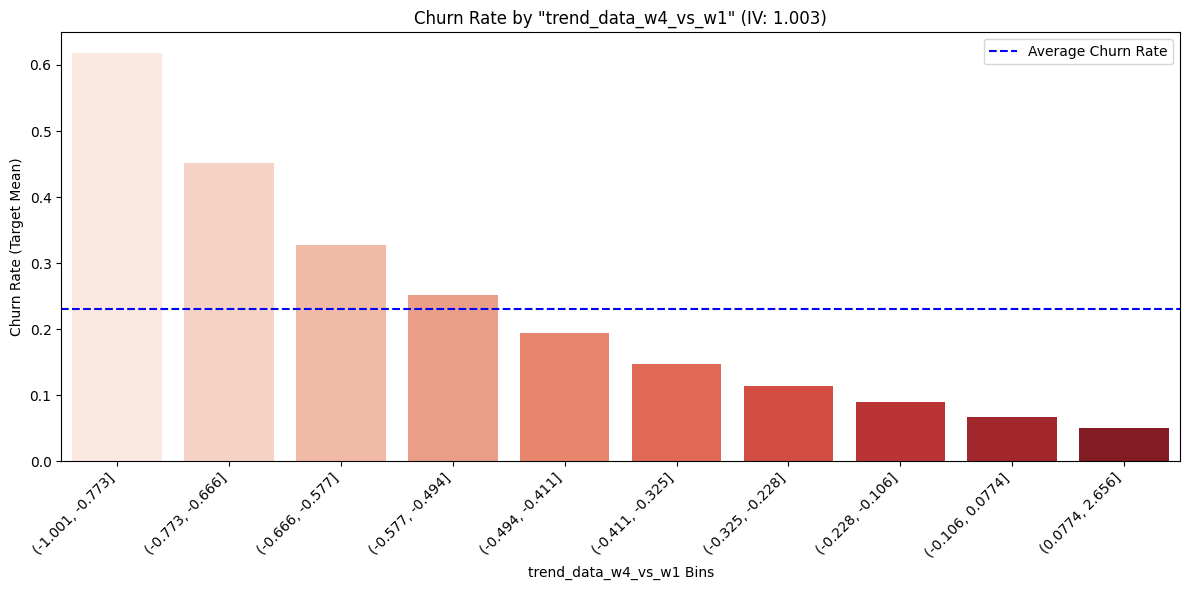

In [28]:
# Plot the feature with the highest IV score
plot_woe_analysis(train_df, 'trend_data_w4_vs_w1', 'churn')

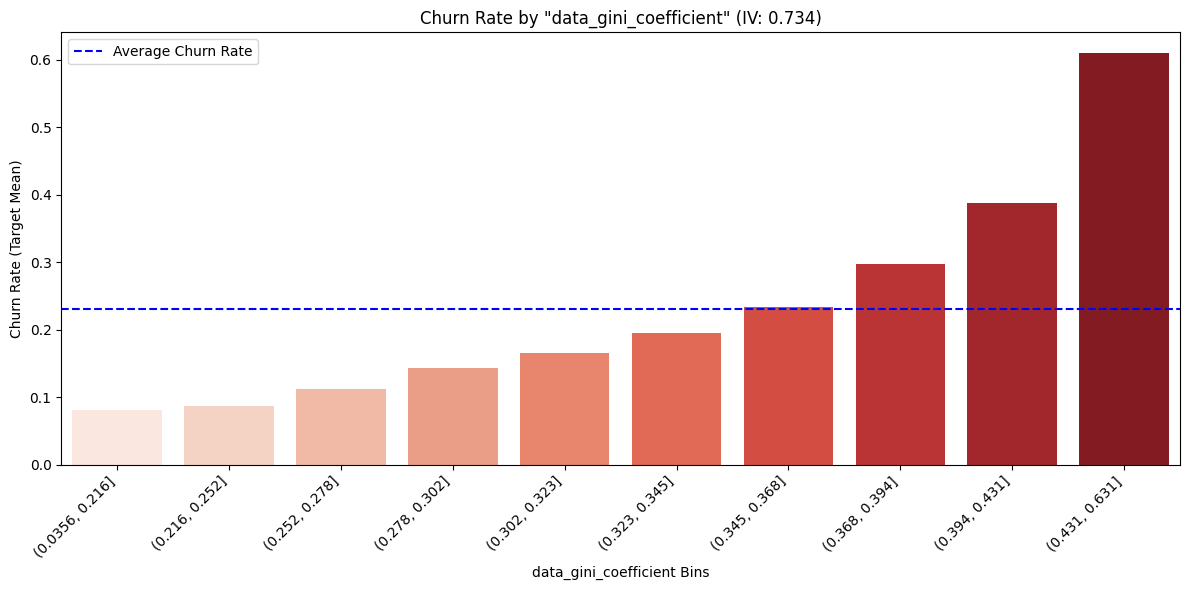

In [30]:
# Plot the feature with the next highest IV score
plot_woe_analysis(train_df, 'data_gini_coefficient', 'churn')

### Weight of Evidence Analysis Summary
**Objective:** Validate the relationship between high-IV features and churn risk.

**Method:** Analyzed Churn Rate across decile bins for Top Selected Features (`trend_data_w4_vs_w1` and `data_gini_coefficient`).

**Key Findings:**
* **Monotonic Trends:** Both features exhibit a clear **"Staircase" pattern**, verifying a monotonic relationship.
    * **Trend:** The `change` metric is highly sensitive; deeper negative changes (drops in usage) correspond to progressively higher churn rates.
    * **Gini Coefficient:** Higher coefficients consistently correlate with higher churn rates across all bins.

* **Interpretation:** This confirms the "Gradual Disengagement" hypothesis (in Section 2.3). Churn is not a sudden event but a measurable decline in engagement during the last days. Also, churners tend to consume data on very few days and are silent on others (Sporadic Habit)
* **Modeling Implication:** The linearity of these trends suggests these features will perform exceptionally well in linear models (Logistic Regression) without requiring complex non-linear transformations.

# 2.6 Segmentation via UMAP & Clustering via K-Means

This paper covers the specific methodology (combining dimensionality reduction with clustering), the domain application (churn/behavioral analysis), and the comparative advantages of these techniques for EDA:
* Delahoz-Domínguez, E., Mendoza-Mendoza, A., & Visbal-Cadavid, D. (2025). Clustering of countries through UMAP and K-Means: A multidimensional analysis of development, governance, and logistics. Logistics, 9(3):108. https://doi.org/10.3390/logistics9030108

In [4]:
features_to_keep = ['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1',
                    'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week',
                    'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1',
                    'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1',
                    'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score',
                    'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2',
                    'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']


Preparing Customer Segmentation Map...
Mapping based on Selected Features: ['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1', 'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week', 'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1', 'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1', 'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score', 'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2', 'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']


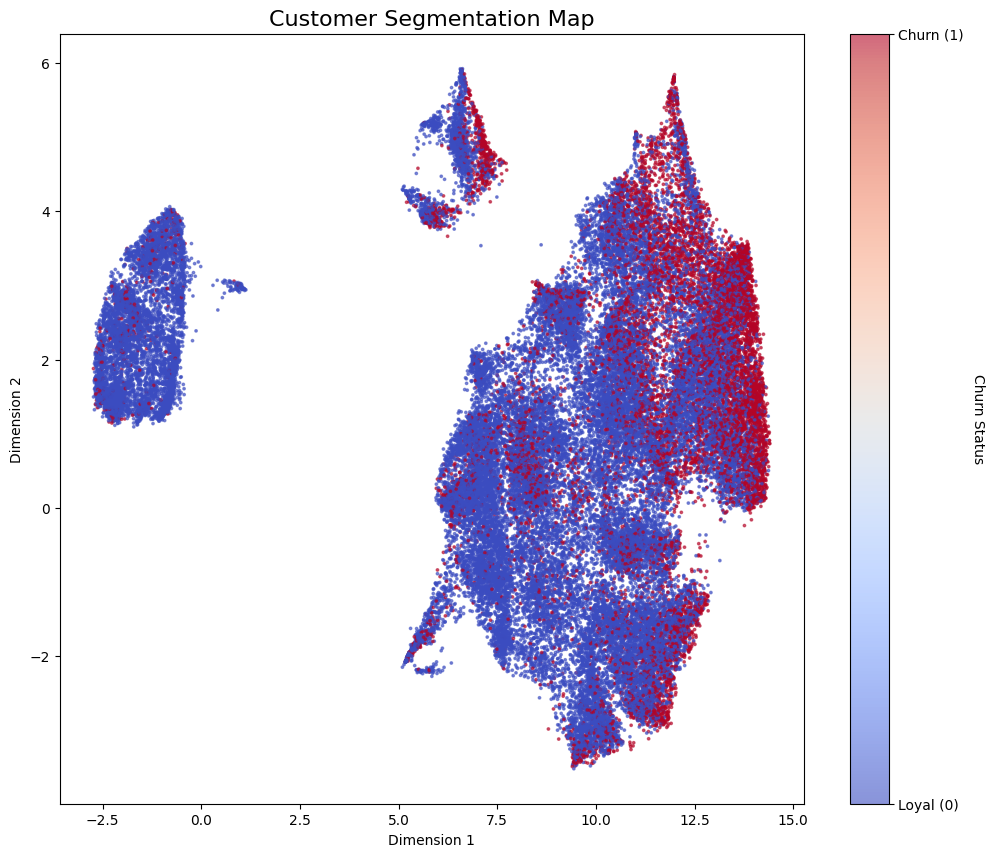

In [5]:
print("Preparing Customer Segmentation Map...")

# Feature Selection: Use the selected features from Section 2.4
print(f"Mapping based on Selected Features: {features_to_keep}")

# reprocessing: Scale the data (Critical for UMAP)
X_segmentation = train_df[features_to_keep].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Run UMAP Projection
# n_neighbors=30: Balances local clusters with global structure
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(X_scaled)

# Prepare Data for Plotting (The Shuffle Trick)
# Combine the coordinates with the Churn label, then SHUFFLE them.
# This ensures Red dots aren't hidden behind the massive pile of Blue dots.
plot_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
plot_df['churn'] = train_df['churn'].values
plot_df_shuffled = plot_df.sample(frac=1, random_state=42) # Shuffle 100% of rows

# The Final Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    plot_df_shuffled['UMAP_1'], 
    plot_df_shuffled['UMAP_2'], 
    c=plot_df_shuffled['churn'], 
    cmap='coolwarm',  # Cool (Blue) = 0, Warm (Red) = 1
    s=3,              # Dot size
    alpha=0.6         # Transparency
)

# Formatting
plt.title('Customer Segmentation Map', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Custom Legend
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Loyal (0)', 'Churn (1)'])
cbar.set_label('Churn Status', rotation=270, labelpad=15)

plt.show()

Cluster Profiling Report:
   Cluster_ID     churn  trend_data_w4_vs_w1  data_gini_coefficient  \
0           0  0.143915            -0.391816               0.312039   
1           1  0.391238            -0.530453               0.345054   
2           2  0.050663             0.199930               0.297424   

   data_volatility_shift  peak_spend_week  spend_volatility_shift  
0               1.128018         2.587880                1.719001  
1               0.927073         1.367754                1.109475  
2               1.648660         2.163328                1.509050  

The cluster with highest churn rate is Cluster 1.


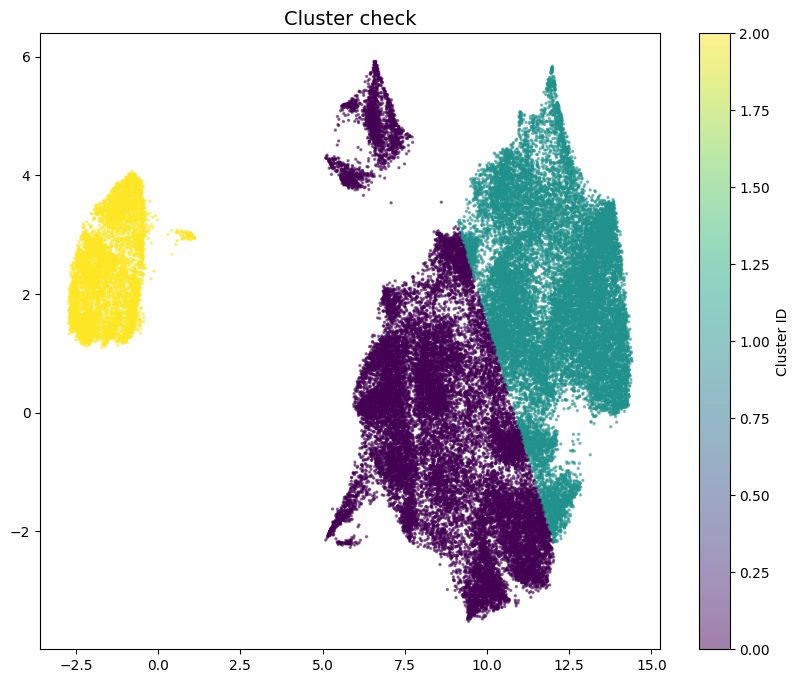

In [7]:
# Cluster the UMAP Map (Use the 'embedding' from the previous step)
# We assume 3 main behaviors: Safe (Blue), Risky (Red), and Ambiguous (Middle)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Add Cluster IDs to a temporary analysis dataframe
analysis_df = train_df.copy()
analysis_df['Cluster_ID'] = cluster_labels

# Profile the Clusters
# We look at Churn Rate + Top Predictive Features
profiling_cols = ['churn', 'trend_data_w4_vs_w1', 'data_gini_coefficient',
                  'data_volatility_shift', 'peak_spend_week',
                  'spend_volatility_shift']
cluster_stats = analysis_df.groupby('Cluster_ID')[profiling_cols].mean().reset_index()

# Identify the cluster with highest churn rate
highest_churn_rate = cluster_stats.loc[cluster_stats['churn'].idxmax(), 'Cluster_ID']

print("Cluster Profiling Report:")
print(cluster_stats)
print(f"\nThe cluster with highest churn rate is Cluster {highest_churn_rate}.")
# Visual Check: Plot the clusters to confirm they match the UMAP shapes
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=2, alpha=0.5)
plt.title(f'Cluster check', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.show()

### Customer Segmentation & Cluster Profiling (UMAP + K-Means) Summary
**Objective:** Visualize high-dimensional customer behavior to isolate high-risk segments and valid the "Disengagement" hypothesis via cluster profiling.

**Method:**
1.  **Projection:** Projected 23 selected features into 2D space using UMAP (`n_neighbors=30`).
2.  **Clustering:** Applied K-Means (k=3) to mathematically profile the visual "Clusters."

**Key Findings:**
The analysis successfully spotted a cluster with highest churn rates **(Cluster 1)** located in the upper-right quadrant. This segment exhibits a clear behavioral signature distinct from the "Safe" segments (Clusters 0 & 2).

**Cluster 1 Profiling ("The Early Burnout" Segment):**

* **`churn` (Risk Level):** **39.1%**.
    * *Interpretation:* This segment has the highest risk, with a churn rate significantly higher than Cluster 0 (~14%) and Cluster 2 (~5%). They are the critical priority for intervention.
* **`peak_spend_week` (The Timing):** **1.37**.
    * *Interpretation:* This is a major differentiator. While safe clusters peaked later in the month (Week ~2.2 to ~2.6), these users maxed out their spending almost immediately in **Week 1** and then trailed off. This suggests "Front-Loaded" value followed by rapid abandonment.
* **`trend_data_w4_vs_w1` (The Decline):** **-0.53**.
    * *Interpretation:* These users experienced a **53% drop** in data usage from the start of the observation to the end. While Cluster 0 also declined (-39%), Cluster 1’s drop is the steepest, confirming the "Burnout" behavior after the early peak.
* **`data_gini_coefficient` (Habit Strength):** **0.35**.
    * *Interpretation:* The highest value among all clusters (vs ~0.30–0.31). This indicates the most **inequality** in daily usage. Instead of a strong, daily habit, these users consume data sporadically—likely heavy usage on peak days followed by days of silence.
* **`data_volatility_shift` (Stability Change):** **0.93**.
    * *Interpretation:* The "Flatline" Effect. The shift is < 1.0, indicating Week 4 was "steadier" than Week 1. Crucial Context: Because this is paired with a negative trend (-53%), this stability is not a healthy habit. It indicates the user settled into a pattern of consistently zero/low usage (flatlining) after their early peak.

**Actionable Insight:**
Cluster 1 represents a critical "Early Burnout" segment (~39% risk) that can be identified by a distinct behavior pattern: front-loaded spending (Week ~1.4 peak) followed immediately by a steep usage decline (-53%). Unlike loyal users who maintain activity, these customers exhibit a "flatlining" signal (Volatility Shift < 1.0) as they disengage.

# Final Exploratory Data Analysis (EDA) Summary

**Objective:** To summarize the data quality, identify the primary drivers of customer churn, and finalize the feature set for predictive modeling.

---

### 1. Data Health & Structure
* **Integrity:** The dataset is high-quality with **zero missing values** and no zero-variance columns.
* **Target Balance:** The churn rate is **23.1%**. This indicates a moderate class imbalance, requiring the use of **SMOTE** or `class_weight='balanced'` during modeling.
* **Multicollinearity:** Strong correlations were found ($|\rho| > 0.7$) between various time-window metrics. A redundancy filter was applied to remove 39 collinear features, retaining the strongest predictors based on Information Value (IV).

---

### 2. Primary Churn Signals (The "Why")
Three specific behavioral patterns dominate the predictive power of the dataset:

* **The "Gradual Fade" (Dominant Signal):**
    The single strongest predictor is $trend\_data\_w4\_vs\_w1$ (IV: 1.00). Churn is rarely a sudden event; it is a measurable process where users significantly reduce data consumption in Week 4 compared to Week 1.
* **Sporadic Usage (Stability):**
    High values in $data\_gini\_coefficient$ and low consistency scores indicate that at-risk users lack a "daily habit." Their usage is sporadic (spiky) rather than steady.
* **Front-Loaded Activity:**
    The feature $peak\_spend\_week$ indicates that churners often max out their spending in **Week 1** and then flatline, whereas retained users peak later in the month.

---

### 3. The "Early Burnout" Profile (The "Who")
Cluster analysis identified a critical high-risk segment (**Cluster 1**, ~39% churn risk) with a distinct signature:
* **Behavior:** They exhibit "Front-Loaded" value. They spend heavily in the first week.
* **Disengagement:** Immediately following the peak, their usage crashes (avg. **-53%** drop by Week 4).
* **Identification:** This segment represents the "Walking Dead"—customers who have mentally churned before the observation window ends.

---

### 4. Final Feature Set Status
* **Input Features:** 23 robust features retained.
* **Dropped:** 39 redundant features (e.g., short-term incremental trends like W3 vs W2) were removed to prevent model instability.
* **Model Readiness:**
    * **Linear Models:** The top features show clear monotonic "staircase" relationships with churn (validated by WoE), making them excellent candidates for Logistic Regression.
    * **Tree Models:** Random Forest importance confirms that the top 3 features account for ~46% of total predictive power.

---
